# Cleaning data

Notes & instructions:

The code performs the following core operations (in the stated below order):
1. Dropping rows pre-1980
2. Removing duplicates
3. Adding financial ratios
4. Adding a few lagged trends
5. Winsorizing all floats at 0.5% and 99%

There are also 2 additional functions:
(6.) Code to subtract mean from all entries in selected columns and divide by standard deviation
(7.) Code to perform a natural log operation on a columns

Input: the compustat file from onedrive (simply change path in the column below)
Output: compustat_df_1980_deduplicated_extended_winsor.csv

Step 1. is straightforward. Step 2. is quite computationally intensive (took my computer 5 minutes). Out of around 900k rows, there are roughly 290k (gykey,fyear) pairs that occur multiple times. Majority of the duplicates (around 270k) doesn't differ in any of the columns, so I just removed those. For the remaining duplicates, I prioritize in order i) the latest datadate entry, ii) presence of TL_flag, iii) index order, to find the duplicats for removal. Step 3. adds some chosen financial ratios. They are all described in the function "add_financial_ratios". Step 4. adds percentage change of selected variables, in a 1, 2 and 5 year time horizon. Step 5. does the winsorization, at 0.5% and 99%. This is quite conservative, but removes the largest outliers. I did not want to winsorize the data further, as different ML models are affected differently by outlier removal. I'd say, depending on your model, you can winsorize the data further, or apply log transformation (header 7.). The same applies to standardising (especially, if we still want to add more financial ratios). The column names follow the compustat convention:

gvkey, company name (conm), ticker (tic), datadate (statement date), fyear (fiscal year). historical NAICS code (naicsh), revenue (revt), operating income before depreciation (oibdp), net income (ni), interest expense (xint), depreciation (dp), total assets (at), current assets (act), cash and short-term investments (che), total liabilities (lt), current liabilities (lct), short-term debt (dlc), long-term debt (dltt), common equity (ceq), shares outstanding (csho), dividends (dv)

added ratios:

gross_margin, net_profit_margin, roa, roe, asset_turnover, cash_to_assets, fixed_asset_intensity, current_ratio, quick_ratio, total_debt, debt_to_assets, debt_to_equity, liabilities_to_assets, interest_coverage, long_term_debt_ratio, book_value_per_share, earnings_per_share, dividend_payout_ratio, dividend_yield, retention_ratio


past pct change:
{original_col_name}_{time_horizon}_year_pct_change

ex. revt_2_year_pct_change  (revenue pct change between fiscal_year and fiscal_year-2)


In [67]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# set the appropriate path below:
compustat_csv_path = "/Users/adamsujecki/PycharmProjects/ST310project_mine/ST310-Predicting-Company-Bankruptcy/data/compustat_annual_1951_onward-copy.csv"

compustat_df_1951 = pd.read_csv(compustat_csv_path)
compustat_df_1951.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022724 entries, 0 to 1022723
Data columns (total 23 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   gvkey     1022724 non-null  int64  
 1   datadate  1022724 non-null  object 
 2   fyear     1022724 non-null  int64  
 3   conm      1022724 non-null  object 
 4   tic       1022406 non-null  object 
 5   naicsh    709771 non-null   float64
 6   revt      893219 non-null   float64
 7   oibdp     772175 non-null   float64
 8   ni        792684 non-null   float64
 9   xint      794946 non-null   float64
 10  dp        839020 non-null   float64
 11  at        898652 non-null   float64
 12  act       662798 non-null   float64
 13  che       791800 non-null   float64
 14  lt        889782 non-null   float64
 15  lct       672762 non-null   float64
 16  dlc       879562 non-null   float64
 17  dltt      891889 non-null   float64
 18  ceq       882595 non-null   float64
 19  csho      857191 non-

# 1. Drop pre-1980 rows

In [32]:
# restricting the dataset to post 1980's entries:

def filter_by_year(df, year_column, min_year):
    df_copy=df.copy()
    return df_copy[df_copy[year_column] >= min_year]

compustat_df_1980 = filter_by_year(compustat_df_1951, "fyear", 1980)

In [7]:
'''
# Quick check to see if we can remove the at_fn columns:
def check_null_entries_col(df,column_name):
    nan_count = df[column_name].isnull().sum()
    print('Number of NaN values:', nan_count)

check_null_entries_col(compustat_df_1980, 'at_fn')
print(len(compustat_df_1980))
# I decided to keep the column, as the footnote mention may contain some more information for the future
'''

Number of NaN values: 803727
1022724


In [33]:
'''
# getting columns names
compustat_df_colnames = compustat_df_1980.columns.tolist()
print(compustat_df_colnames)

# creating list of columns with float entries based off df.info()
compustat_float_column_names = compustat_df_colnames[6:21]
print(compustat_float_column_names)

compustat_df_1980.head(10)
'''

['gvkey', 'datadate', 'fyear', 'conm', 'tic', 'naicsh', 'revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'csho', 'dv', 'at_fn', 'TL_flag']
['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che', 'lt', 'lct', 'dlc', 'dltt', 'ceq', 'csho', 'dv']


,gvkey,datadate,fyear,conm,tic,naicsh,revt,oibdp,ni,xint,...,che,lt,lct,dlc,dltt,ceq,csho,dv,at_fn,TL_flag
27,1001,1980-12-31,1980,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
28,1001,1980-12-31,1980,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
29,1001,1981-12-31,1981,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
30,1001,1981-12-31,1981,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
31,1001,1982-12-31,1982,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
32,1001,1982-12-31,1982,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
33,1003,1983-12-31,1983,A.A. IMPORTING CO INC,ANTQ,NaN,13.793,2.138,1.050,0.130,...,2.023,2.434,1.484,0.25,0.950,6.095,2.683,0.0,NaN,0
34,1003,1983-12-31,1983,A.A. IMPORTING CO INC,ANTQ,NaN,13.793,2.138,1.050,0.130,...,2.023,2.434,1.484,0.25,0.950,6.095,2.683,0.0,NaN,0
35,1001,1983-12-31,1983,A & M FOOD SERVICES INC,AMFD.,NaN,25.395,2.650,1.135,0.763,...,4.280,6.257,1.913,0.52,4.344,7.823,3.568,0.0,NaN,0
36,1001,1983-12-31,1983,A & M FOOD SERVICES INC,AMFD.,NaN,25.395,2.650,1.135,0.763,...,4.280,6.257,1.913,0.52,4.344,7.823,3.568,0.0,NaN,0


Variables retrieved include:
   - Firm identifiers: gvkey, company name (conm), ticker (tic)
   - Time identifiers: datadate (statement date), fyear (fiscal year)
   - Industry classification: historical NAICS code (naicsh)
   - Income statement items: revenue (revt), operating income
     before depreciation (oibdp), net income (ni), interest
     expense (xint), depreciation (dp)
   - Balance sheet items: total assets (at), current assets (act),
     cash and short-term investments (che), total liabilities (lt),
     current liabilities (lct), short-term debt (dlc), long-term
     debt (dltt), common equity (ceq), shares outstanding (csho)
   - Payouts: dividends (dv)

# 2. Checking and removing duplicates

In [38]:
'''
# Count unique gvkey-fyear combinations
unique_combinations = compustat_df_1980.groupby(['gvkey', 'fyear']).ngroups

# Compare to total rows
total_rows = len(compustat_df_1980)

print(f"Unique gvkey-fyear combinations: {unique_combinations:,}")
print(f"Total rows in dataset: {total_rows:,}")
print(f"Duplicate rows: {total_rows - unique_combinations:,}")

# If you want to see which combinations have duplicates:
if total_rows != unique_combinations:
    duplicates = compustat_df_1980_extended.groupby(['gvkey', 'fyear']).size().reset_index(name='count')
    duplicates = duplicates[duplicates['count'] > 1]
    print(f"\nNumber of gvkey-fyear pairs with duplicates: {len(duplicates)}")
    print("\nSample duplicates:")
    print(duplicates.head(10))
'''

Unique gvkey-fyear combinations: 487,606
Total rows in dataset: 898,777
Duplicate rows: 411,171


'\n# If you want to see which combinations have duplicates:\nif total_rows != unique_combinations:\n    duplicates = compustat_df_1980_extended.groupby([\'gvkey\', \'fyear\']).size().reset_index(name=\'count\')\n    duplicates = duplicates[duplicates[\'count\'] > 1]\n    print(f"\nNumber of gvkey-fyear pairs with duplicates: {len(duplicates)}")\n    print("\nSample duplicates:")\n    print(duplicates.head(10))\n'

In [26]:
'''
# Identify all duplicate rows (keep all copies)
dup_keys = compustat_df_1980[compustat_df_1980.duplicated(subset=['gvkey', 'fyear'], keep=False)]
dup_keys = dup_keys.sort_values(['gvkey', 'fyear'])

# Group duplicates by gvkey-fyear
grouped = dup_keys.groupby(['gvkey', 'fyear'])

# Count pairs with same datadate
same_datadate = grouped['datadate'].apply(lambda x: x.nunique() == 1).sum()
diff_datadate = len(grouped) - same_datadate

print(f"Total duplicate gvkey-fyear groups: {len(grouped):,}")
print(f"Groups with same datadate: {same_datadate:,}")
print(f"Groups with different datadate: {diff_datadate:,}")

# Check how many differ by fewer than 4 columns out of revt, at, lt, TL_flag
comparison_cols = ['revt', 'at', 'lt', 'TL_flag']

def count_differing_cols(group):
    """Count how many of the comparison columns have more than one unique value."""
    differing = 0
    for col in comparison_cols:
        # dropna=False ensures NaN is treated as a value
        if group[col].nunique(dropna=False) > 1:
            differing += 1
    return differing

cols_differing = grouped.apply(count_differing_cols)

# Summarize results
print(f"\n--- Differences in key columns ({', '.join(comparison_cols)}) ---")
for i in range(5):
    count = (cols_differing == i).sum()
    print(f"Groups differing in exactly {i} columns: {count:,}")

print(f"\nGroups differing in fewer than 4 columns: {(cols_differing < 4).sum():,}")
print(f"Groups differing in all 4 columns: {(cols_differing == 4).sum():,}")
'''

Total duplicate gvkey-fyear groups: 296,883
Groups with same datadate: 296,869
Groups with different datadate: 14

--- Differences in key columns (revt, at, lt, TL_flag) ---
Groups differing in exactly 0 columns: 282,481
Groups differing in exactly 1 columns: 13,343
Groups differing in exactly 2 columns: 503
Groups differing in exactly 3 columns: 556
Groups differing in exactly 4 columns: 0

Groups differing in fewer than 4 columns: 296,883
Groups differing in all 4 columns: 0


/var/folders/6h/0b8lv2fn4rbg9fq605gky45h0000gn/T/ipykernel_936/1850605015.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cols_differing = grouped.apply(count_differing_cols)


In [27]:
'''
# Identify columns that vary within duplicates
dup_keys = compustat_df_1980[compustat_df_1980.duplicated(subset=['gvkey', 'fyear'], keep=False)]
dup_keys = dup_keys.sort_values(['gvkey', 'fyear'])

# Check which columns differ within duplicate groups
sample_gvkey = dup_keys['gvkey'].iloc[0]
sample_fyear = dup_keys[dup_keys['gvkey'] == sample_gvkey]['fyear'].iloc[0]

print(compustat_df_1980[(compustat_df_1980['gvkey'] == sample_gvkey) & (compustat_df_1980['fyear'] == sample_fyear)].T)
'''

                               27                       28
gvkey                        1001                     1001
datadate               1980-12-31               1980-12-31
fyear                        1980                     1980
conm      A & M FOOD SERVICES INC  A & M FOOD SERVICES INC
tic                         AMFD.                    AMFD.
naicsh                        NaN                      NaN
revt                          NaN                      NaN
oibdp                         NaN                      NaN
ni                            NaN                      NaN
xint                          NaN                      NaN
dp                            NaN                      NaN
at                            NaN                      NaN
act                           NaN                      NaN
che                           NaN                      NaN
lt                            NaN                      NaN
lct                           NaN                      N

In [34]:
def deduplicate_compustat(df):
    """
    Remove duplicate gvkey-fyear combinations from a Compustat dataset.

    Parameters:
    -----------
    df : pandas DataFrame
        Must contain columns: gvkey, fyear, datadate, TL_flag

    Returns:
    --------
    pandas DataFrame with unique gvkey-fyear combinations

    Deduplication Logic:
    --------------------
    For each gvkey-fyear group with multiple rows:

    1. If ALL columns are identical across duplicates:
       - Keep the last row in the original dataset order
       - (Equivalent to df.drop_duplicates(keep='last'))

    2. If ANY columns differ across duplicates:
       - First priority: Keep the row with the most recent (max) datadate
       - Second priority (if datadate tied): Keep the row with TL_flag = 1
       - Third priority (if still tied): Keep the first row encountered

    Edge Case Behavior:
    -------------------
    If duplicates have the same datadate AND the same TL_flag (or both have
    TL_flag = 0, or both have TL_flag = 1), the function keeps whichever row
    appears first after sorting by datadate (descending) and TL_flag (descending).
    In practice, this means the selection is arbitrary but deterministic —
    running the function twice on the same input will always produce the
    same output.
    """

    df = df.copy()

    # Add original row index to track position
    df['_original_order'] = range(len(df))

    # Identify which gvkey-fyear groups have duplicates
    dup_mask = df.duplicated(subset=['gvkey', 'fyear'], keep=False)

    # Split into non-duplicates and duplicates
    df_unique = df[~dup_mask].copy()
    df_dups = df[dup_mask].copy()

    if len(df_dups) == 0:
        # No duplicates, return original (minus helper column)
        return df.drop(columns=['_original_order'])

    # For duplicates, determine if all columns are identical within each group
    # Compare all columns except our helper column
    compare_cols = [c for c in df.columns if c not in ['gvkey', 'fyear', '_original_order']]

    def all_cols_identical(group):
        """Check if all values in all columns are identical within group."""
        for col in compare_cols:
            # nunique(dropna=False) treats NaN as a distinct value
            if group[col].nunique(dropna=False) > 1:
                return False
        return True

    # Group duplicates and classify
    grouped = df_dups.groupby(['gvkey', 'fyear'])

    # Identify groups where all columns are identical
    identical_mask = grouped.apply(all_cols_identical)
    identical_keys = identical_mask[identical_mask].index.tolist()

    # Split duplicates into identical vs different
    df_dups_identical = df_dups[
        df_dups.set_index(['gvkey', 'fyear']).index.isin(identical_keys)
    ].copy()
    df_dups_different = df_dups[
        ~df_dups.set_index(['gvkey', 'fyear']).index.isin(identical_keys)
    ].copy()

    # --- Handle identical duplicates: keep last occurrence ---
    df_dups_identical_deduped = (
        df_dups_identical
        .sort_values('_original_order')
        .drop_duplicates(subset=['gvkey', 'fyear'], keep='last')
    )

    # --- Handle different duplicates: prioritize by datadate, then TL_flag ---
    df_dups_different_deduped = (
        df_dups_different
        .sort_values(
            ['gvkey', 'fyear', 'datadate', 'TL_flag', '_original_order'],
            ascending=[True, True, False, False, True]
        )
        .drop_duplicates(subset=['gvkey', 'fyear'], keep='first')
    )

    # Combine all pieces back together
    df_result = pd.concat([
        df_unique,
        df_dups_identical_deduped,
        df_dups_different_deduped
    ], ignore_index=True)

    # Restore original order and clean up
    df_result = df_result.sort_values('_original_order').drop(columns=['_original_order'])
    df_result = df_result.reset_index(drop=True)

    return df_result

In [35]:
compustat_df_1980_deduplicated = deduplicate_compustat(compustat_df_1980)

/var/folders/6h/0b8lv2fn4rbg9fq605gky45h0000gn/T/ipykernel_936/458599537.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  identical_mask = grouped.apply(all_cols_identical)


In [36]:
compustat_df_1980_deduplicated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487606 entries, 0 to 487605
Data columns (total 23 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   gvkey     487606 non-null  int64  
 1   datadate  487606 non-null  object 
 2   fyear     487606 non-null  int64  
 3   conm      487606 non-null  object 
 4   tic       487403 non-null  object 
 5   naicsh    359011 non-null  float64
 6   revt      397091 non-null  float64
 7   oibdp     351477 non-null  float64
 8   ni        356282 non-null  float64
 9   xint      377662 non-null  float64
 10  dp        385478 non-null  float64
 11  at        399664 non-null  float64
 12  act       334680 non-null  float64
 13  che       358035 non-null  float64
 14  lt        398845 non-null  float64
 15  lct       338903 non-null  float64
 16  dlc       396405 non-null  float64
 17  dltt      398300 non-null  float64
 18  ceq       398815 non-null  float64
 19  csho      414630 non-null  float64
 20  dv  

In [40]:
'''
# think of this as a checkpoint

compustat_df_1980_deduplicated.to_csv(
    "compustat_df_1980_deduplicated.csv",
    index=False
)
'''

# 3. Adding new ratios

In [41]:
# Creating new useful financial ratios:
def add_financial_ratios(df):
    df = df.copy()

    # Profitability ratios

    # Gross/Operating Margin: Operating income before depreciation as a
    # percentage of revenue. Measures operational efficiency before D&A.
    df['gross_margin'] = df['oibdp'] / df['revt']

    # Net Profit Margin: Net income as a percentage of revenue.
    # Measures bottom-line profitability after all expenses.
    df['net_profit_margin'] = df['ni'] / df['revt']

    # Return on Assets (ROA): Net income divided by total assets.
    # Measures how efficiently a company uses its assets to generate profit.
    df['roa'] = df['ni'] / df['at']

    # Return on Equity (ROE): Net income divided by common equity.
    # Measures the return generated on shareholders' investment.
    df['roe'] = df['ni'] / df['ceq']


    # Asset ratios

    # Asset Turnover: Revenue divided by total assets.
    # Measures how efficiently assets are used to generate sales.
    df['asset_turnover'] = df['revt'] / df['at']

    # Cash-to-Assets: Cash and short-term investments divided by total assets.
    # Measures the liquidity cushion relative to company size.
    df['cash_to_assets'] = df['che'] / df['at']

    # Fixed Asset Intensity: Non-current assets as a proportion of total assets.
    # Indicates capital intensity and long-term asset reliance.
    df['fixed_asset_intensity'] = (df['at'] - df['act']) / df['at']


    # Liquidity ratios

    # Current Ratio: Current assets divided by current liabilities.
    # Measures ability to pay short-term obligations with short-term assets.
    df['current_ratio'] = df['act'] / df['lct']

    # Quick Ratio (Cash Ratio): Cash divided by current liabilities.
    # Conservative liquidity measure using only the most liquid assets.
    df['quick_ratio'] = df['che'] / df['lct']


    # Solvency/leverage ratios

    # Total Debt: Sum of short-term and long-term debt
    df['total_debt'] = df['dlc'] + df['dltt']

    # Debt-to-Assets: Total debt divided by total assets.
    # Measures the proportion of assets financed by debt.
    df['debt_to_assets'] = df['total_debt'] / df['at']

    # Debt-to-Equity: Total debt divided by common equity.
    # Measures financial leverage; higher values indicate more debt financing.
    df['debt_to_equity'] = df['total_debt'] / df['ceq']

    # Liabilities-to-Assets: Total liabilities divided by total assets.
    # Broader measure of obligations relative to assets (includes all liabilities).
    df['liabilities_to_assets'] = df['lt'] / df['at']

    # Interest Coverage: Operating income before depreciation divided by interest expense.
    # Measures ability to service debt; higher is better.
    # Note: Using oibdp (before D&A) for more conservative coverage estimate.
    df['interest_coverage'] = df['oibdp'] / df['xint']

    # Long-term Debt Ratio: Long-term debt divided by (long-term debt + equity).
    # Measures the proportion of long-term capital that is debt-financed.
    df['long_term_debt_ratio'] = df['dltt'] / (df['dltt'] + df['ceq'])


    # Equity and shareholder ratios

    # Book Value per Share: Common equity divided by shares outstanding.
    # Represents the accounting value of each share.
    df['book_value_per_share'] = df['ceq'] / df['csho']

    # Earnings per Share (EPS): Net income divided by shares outstanding.
    # Profit attributable to each share of common stock.
    df['earnings_per_share'] = df['ni'] / df['csho']

    # Dividend Payout Ratio: Dividends divided by net income.
    # Proportion of earnings distributed to shareholders as dividends.
    df['dividend_payout_ratio'] = df['dv'] / df['ni']

    # Dividend Yield (Book-based): Dividends divided by common equity.
    # Proxy for dividend yield using book equity (market cap not available).
    df['dividend_yield'] = df['dv'] / df['ceq']

    # Retention Ratio: Proportion of earnings retained (not paid as dividends).
    # Indicates reinvestment rate; (1 - payout ratio).
    df['retention_ratio'] = (df['ni'] - df['dv']) / df['ni']

    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [42]:
compustat_df_1980_deduplicated_extended = add_financial_ratios(compustat_df_1980_deduplicated)
compustat_df_1980_deduplicated_extended.head()

,gvkey,datadate,fyear,conm,tic,naicsh,revt,oibdp,ni,xint,...,debt_to_assets,debt_to_equity,liabilities_to_assets,interest_coverage,long_term_debt_ratio,book_value_per_share,earnings_per_share,dividend_payout_ratio,dividend_yield,retention_ratio
0,1001,1980-12-31,1980,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,1981-12-31,1981,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,1982-12-31,1982,A & M FOOD SERVICES INC,AMFD.,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1003,1983-12-31,1983,A.A. IMPORTING CO INC,ANTQ,NaN,13.793,2.138,1.050,0.130,...,0.140696,0.196883,0.285379,16.446154,0.134847,2.271711,0.391353,0.0,0.0,1.0
4,1001,1983-12-31,1983,A & M FOOD SERVICES INC,AMFD.,NaN,25.395,2.650,1.135,0.763,...,0.345455,0.621756,0.444389,3.473132,0.357031,2.192545,0.318105,0.0,0.0,1.0


In [45]:
compustat_df_1980_deduplicated_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487606 entries, 0 to 487605
Data columns (total 43 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   gvkey                  487606 non-null  int64  
 1   datadate               487606 non-null  object 
 2   fyear                  487606 non-null  int64  
 3   conm                   487606 non-null  object 
 4   tic                    487403 non-null  object 
 5   naicsh                 359011 non-null  float64
 6   revt                   397091 non-null  float64
 7   oibdp                  351477 non-null  float64
 8   ni                     356282 non-null  float64
 9   xint                   377662 non-null  float64
 10  dp                     385478 non-null  float64
 11  at                     399664 non-null  float64
 12  act                    334680 non-null  float64
 13  che                    358035 non-null  float64
 14  lt                     398845 non-nu

# 4. Adding trends

In [49]:
def add_lagged_growth(df, lag_periods=[1, 2, 5]):
    """
    Add lagged growth variables for key financial metrics.

    Parameters:
    -----------
    df : pandas DataFrame
        Must contain columns: gvkey, fyear, revt, at, ni, oibdp, ceq,
        and either 'total_debt' or both 'dlc' and 'dltt'.
        Assumes gvkey-fyear combinations are unique.
    lag_periods : list, default [1, 2, 5]
        List of year lags to calculate (e.g., [1, 2, 5] for 1, 2, and 5 years).

    Returns:
    --------
    pandas DataFrame with added growth columns

    Notes:
    ------
    - Function handles sorting internally
    - Growth is calculated as (current - lagged) / |lagged|
    - Returns NaN when:
        * The lagged year doesn't exist for that company (e.g., company only
          has 2 years of data, so 5-year lag is NaN)
        * The lagged value is NaN
        * The lagged value is zero (would cause division by zero)
    - Uses merge on fyear to handle gaps in time series (e.g., if a company
      is missing year 2020, the 1-year growth for 2021 will be NaN)

    Output Columns:
    ---------------
    For each lag period (e.g., 1, 2, 5), adds:
        - revenue_growth_{lag}y: Percentage change in revenue (revt)
        - asset_growth_{lag}y: Percentage change in total assets (at)
        - net_income_growth_{lag}y: Percentage change in net income (ni)
        - operating_income_growth_{lag}y: Percentage change in operating
          income before depreciation (oibdp)
        - equity_growth_{lag}y: Percentage change in common equity (ceq)
        - debt_change_{lag}y: Percentage change in total debt (dlc + dltt)
    """

    df = df.copy()

    # Sort by company and fiscal year
    df = df.sort_values(['gvkey', 'fyear']).reset_index(drop=True)


    # Define variables to calculate growth for
    # Format: (source_column, output_prefix)
    growth_vars = [
    'revt',
    'at',
    'ni',
    'oibdp',
    'ceq',
    'total_debt']

    # Columns needed for lagged calculations
    lag_source_cols = ['gvkey', 'fyear', 'revt', 'at', 'ni', 'oibdp', 'ceq', 'total_debt']

    for lag in lag_periods:
        # Create a lagged reference DataFrame
        # We shift fyear FORWARD so that when we merge, the "lagged" row's
        # fyear + lag = current row's fyear
        lagged_df = df[lag_source_cols].copy()
        lagged_df['fyear'] = lagged_df['fyear'] + lag

        # Rename columns to indicate they are lagged values
        rename_dict = {col: f'{col}_lag' for col in lag_source_cols if col not in ['gvkey', 'fyear']}
        lagged_df = lagged_df.rename(columns=rename_dict)

        # Merge current data with lagged data on gvkey and fyear
        # Left merge ensures we keep all current rows; unmatched lags become NaN
        df = df.merge(lagged_df, on=['gvkey', 'fyear'], how='left')

        # Calculate percentage change for each variable
        for src_col in growth_vars:
            lag_col = f'{src_col}_lag'
            out_col = f'{src_col}_{lag}_year_pct_change'

            # Pct change = (current - lagged) / |lagged|
            # Using abs() in denominator to handle negative base values properly
            # e.g., if net income went from -100 to -50, growth = (-50 - -100) / |-100| = 0.5 (50% improvement)
            df[out_col] = (df[src_col] - df[lag_col]) / df[lag_col].abs()

        # Drop the temporary lagged columns
        lag_cols_to_drop = [c for c in df.columns if c.endswith('_lag')]
        df = df.drop(columns=lag_cols_to_drop)

    # Replace infinite values (from division by zero) with NaN
    df = df.replace([np.inf, -np.inf], np.nan)

    return df

In [50]:
compustat_df_1980_deduplicated_extended_growth = add_lagged_growth(compustat_df_1980_deduplicated_extended)
compustat_df_1980_deduplicated_extended_growth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487606 entries, 0 to 487605
Data columns (total 61 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gvkey                         487606 non-null  int64  
 1   datadate                      487606 non-null  object 
 2   fyear                         487606 non-null  int64  
 3   conm                          487606 non-null  object 
 4   tic                           487403 non-null  object 
 5   naicsh                        359011 non-null  float64
 6   revt                          397091 non-null  float64
 7   oibdp                         351477 non-null  float64
 8   ni                            356282 non-null  float64
 9   xint                          377662 non-null  float64
 10  dp                            385478 non-null  float64
 11  at                            399664 non-null  float64
 12  act                           334680 non-nul

# 5. Winsorization

In [60]:
import matplotlib.pyplot as plt
from scipy import stats

def plot_winsorization_histograms(df, cols=None, figsize=(20, 24), bins=100):
    """
    Plot histograms of standardized columns to help choose winsorization thresholds.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing financial variables
    cols : list, optional
        List of columns to plot. If None, uses default financial columns.
    figsize : tuple, default (20, 24)
        Figure size (width, height)
    bins : int, default 100
        Number of histogram bins

    Returns:
    --------
    DataFrame with summary statistics for each column
    """

    # Default columns if not specified
    if cols is None:
         cols = ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che',
                'lt', 'lct', 'dlc', 'dltt', 'ceq', 'csho', 'dv',
                'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'book_value_per_share','earnings_per_share', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change']

    # Filter to columns that exist in the dataframe
    cols = [c for c in cols if c in df.columns]

    # Calculate number of rows needed for subplots
    n_cols = 3
    n_rows = int(np.ceil(len(cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    # Store summary statistics
    summary_stats = []

    for i, col in enumerate(cols):
        ax = axes[i]

        # Get non-null values
        data = df[col].dropna()

        if len(data) == 0:
            ax.set_title(f'{col}\n(No data)')
            continue

        # Standardize the data (z-scores)
        z_scores = stats.zscore(data)

        # Calculate percentiles on original data
        percentiles = {
            '0.5%': np.percentile(data, 0.5),
            '1%': np.percentile(data, 1),
            '5%': np.percentile(data, 5),
            '25%': np.percentile(data, 25),
            '50%': np.percentile(data, 50),
            '75%': np.percentile(data, 75),
            '95%': np.percentile(data, 95),
            '99%': np.percentile(data, 99),
            '99.5%': np.percentile(data, 99.5),
        }

        # Store summary statistics
        summary_stats.append({
            'column': col,
            'count': len(data),
            'mean': data.mean(),
            'std': data.std(),
            'min': data.min(),
            'p0.5': percentiles['0.5%'],
            'p1': percentiles['1%'],
            'p5': percentiles['5%'],
            'p25': percentiles['25%'],
            'p50': percentiles['50%'],
            'p75': percentiles['75%'],
            'p95': percentiles['95%'],
            'p99': percentiles['99%'],
            'p99.5': percentiles['99.5%'],
            'max': data.max(),
            'skewness': stats.skew(data),
            'kurtosis': stats.kurtosis(data)
        })

        # Plot histogram of z-scores (clipped for visualization)
        z_clipped = np.clip(z_scores, -5, 5)
        ax.hist(z_clipped, bins=bins, edgecolor='none', alpha=0.7)

        # Add vertical lines for common z-score thresholds
        for z_thresh, color, ls in [(-3, 'red', '--'), (3, 'red', '--'),
                                      (-2, 'orange', ':'), (2, 'orange', ':')]:
            ax.axvline(x=z_thresh, color=color, linestyle=ls, linewidth=1.5)

        # Calculate percentage of outliers
        pct_beyond_2 = (np.abs(z_scores) > 2).sum() / len(z_scores) * 100
        pct_beyond_3 = (np.abs(z_scores) > 3).sum() / len(z_scores) * 100

        ax.set_title(f'{col}\n|z|>2: {pct_beyond_2:.1f}%, |z|>3: {pct_beyond_3:.1f}%')
        ax.set_xlabel('Z-score (clipped to ±5)')
        ax.set_ylabel('Frequency')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.savefig('winsorization_histograms.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_stats)

    return summary_df


def plot_percentile_comparison(df, cols=None, figsize=(16, 10)):
    """
    Plot a heatmap-style comparison of percentile values across columns.
    Useful for comparing relative extremity of outliers.

    Parameters:
    -----------
    df : pandas DataFrame
    cols : list, optional
    figsize : tuple
    """

    if cols is None:
        cols = ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che',
                'lt', 'lct', 'dlc', 'dltt', 'ceq', 'csho', 'dv',
                'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'book_value_per_share','earnings_per_share', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change']

    cols = [c for c in cols if c in df.columns]

    percentile_levels = [0.5, 1, 5, 25, 50, 75, 95, 99, 99.5]

    # Calculate ratio of percentile to median for each column
    ratios = []
    for col in cols:
        data = df[col].dropna()
        median = np.percentile(data, 50)

        # Avoid division by zero
        if median == 0:
            median = 1e-10

        row = {'column': col}
        for p in percentile_levels:
            val = np.percentile(data, p)
            row[f'p{p}'] = val
            row[f'p{p}_ratio'] = val / abs(median)
        ratios.append(row)

    ratio_df = pd.DataFrame(ratios)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)

    # Extract ratio columns for heatmap
    ratio_cols = [f'p{p}_ratio' for p in percentile_levels]
    heatmap_data = ratio_df[ratio_cols].values

    # Use log scale for better visualization of extreme ratios
    heatmap_log = np.sign(heatmap_data) * np.log1p(np.abs(heatmap_data))

    im = ax.imshow(heatmap_log, aspect='auto', cmap='RdYlBu_r')

    ax.set_xticks(range(len(percentile_levels)))
    ax.set_xticklabels([f'{p}%' for p in percentile_levels])
    ax.set_yticks(range(len(cols)))
    ax.set_yticklabels(cols)

    # Add colorbar
    plt.colorbar(im, ax=ax, label='log(1 + |ratio to median|)')

    ax.set_title('Percentile Values Relative to Median (log scale)')
    ax.set_xlabel('Percentile')
    ax.set_ylabel('Variable')

    plt.tight_layout()
    plt.savefig('percentile_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    return ratio_df

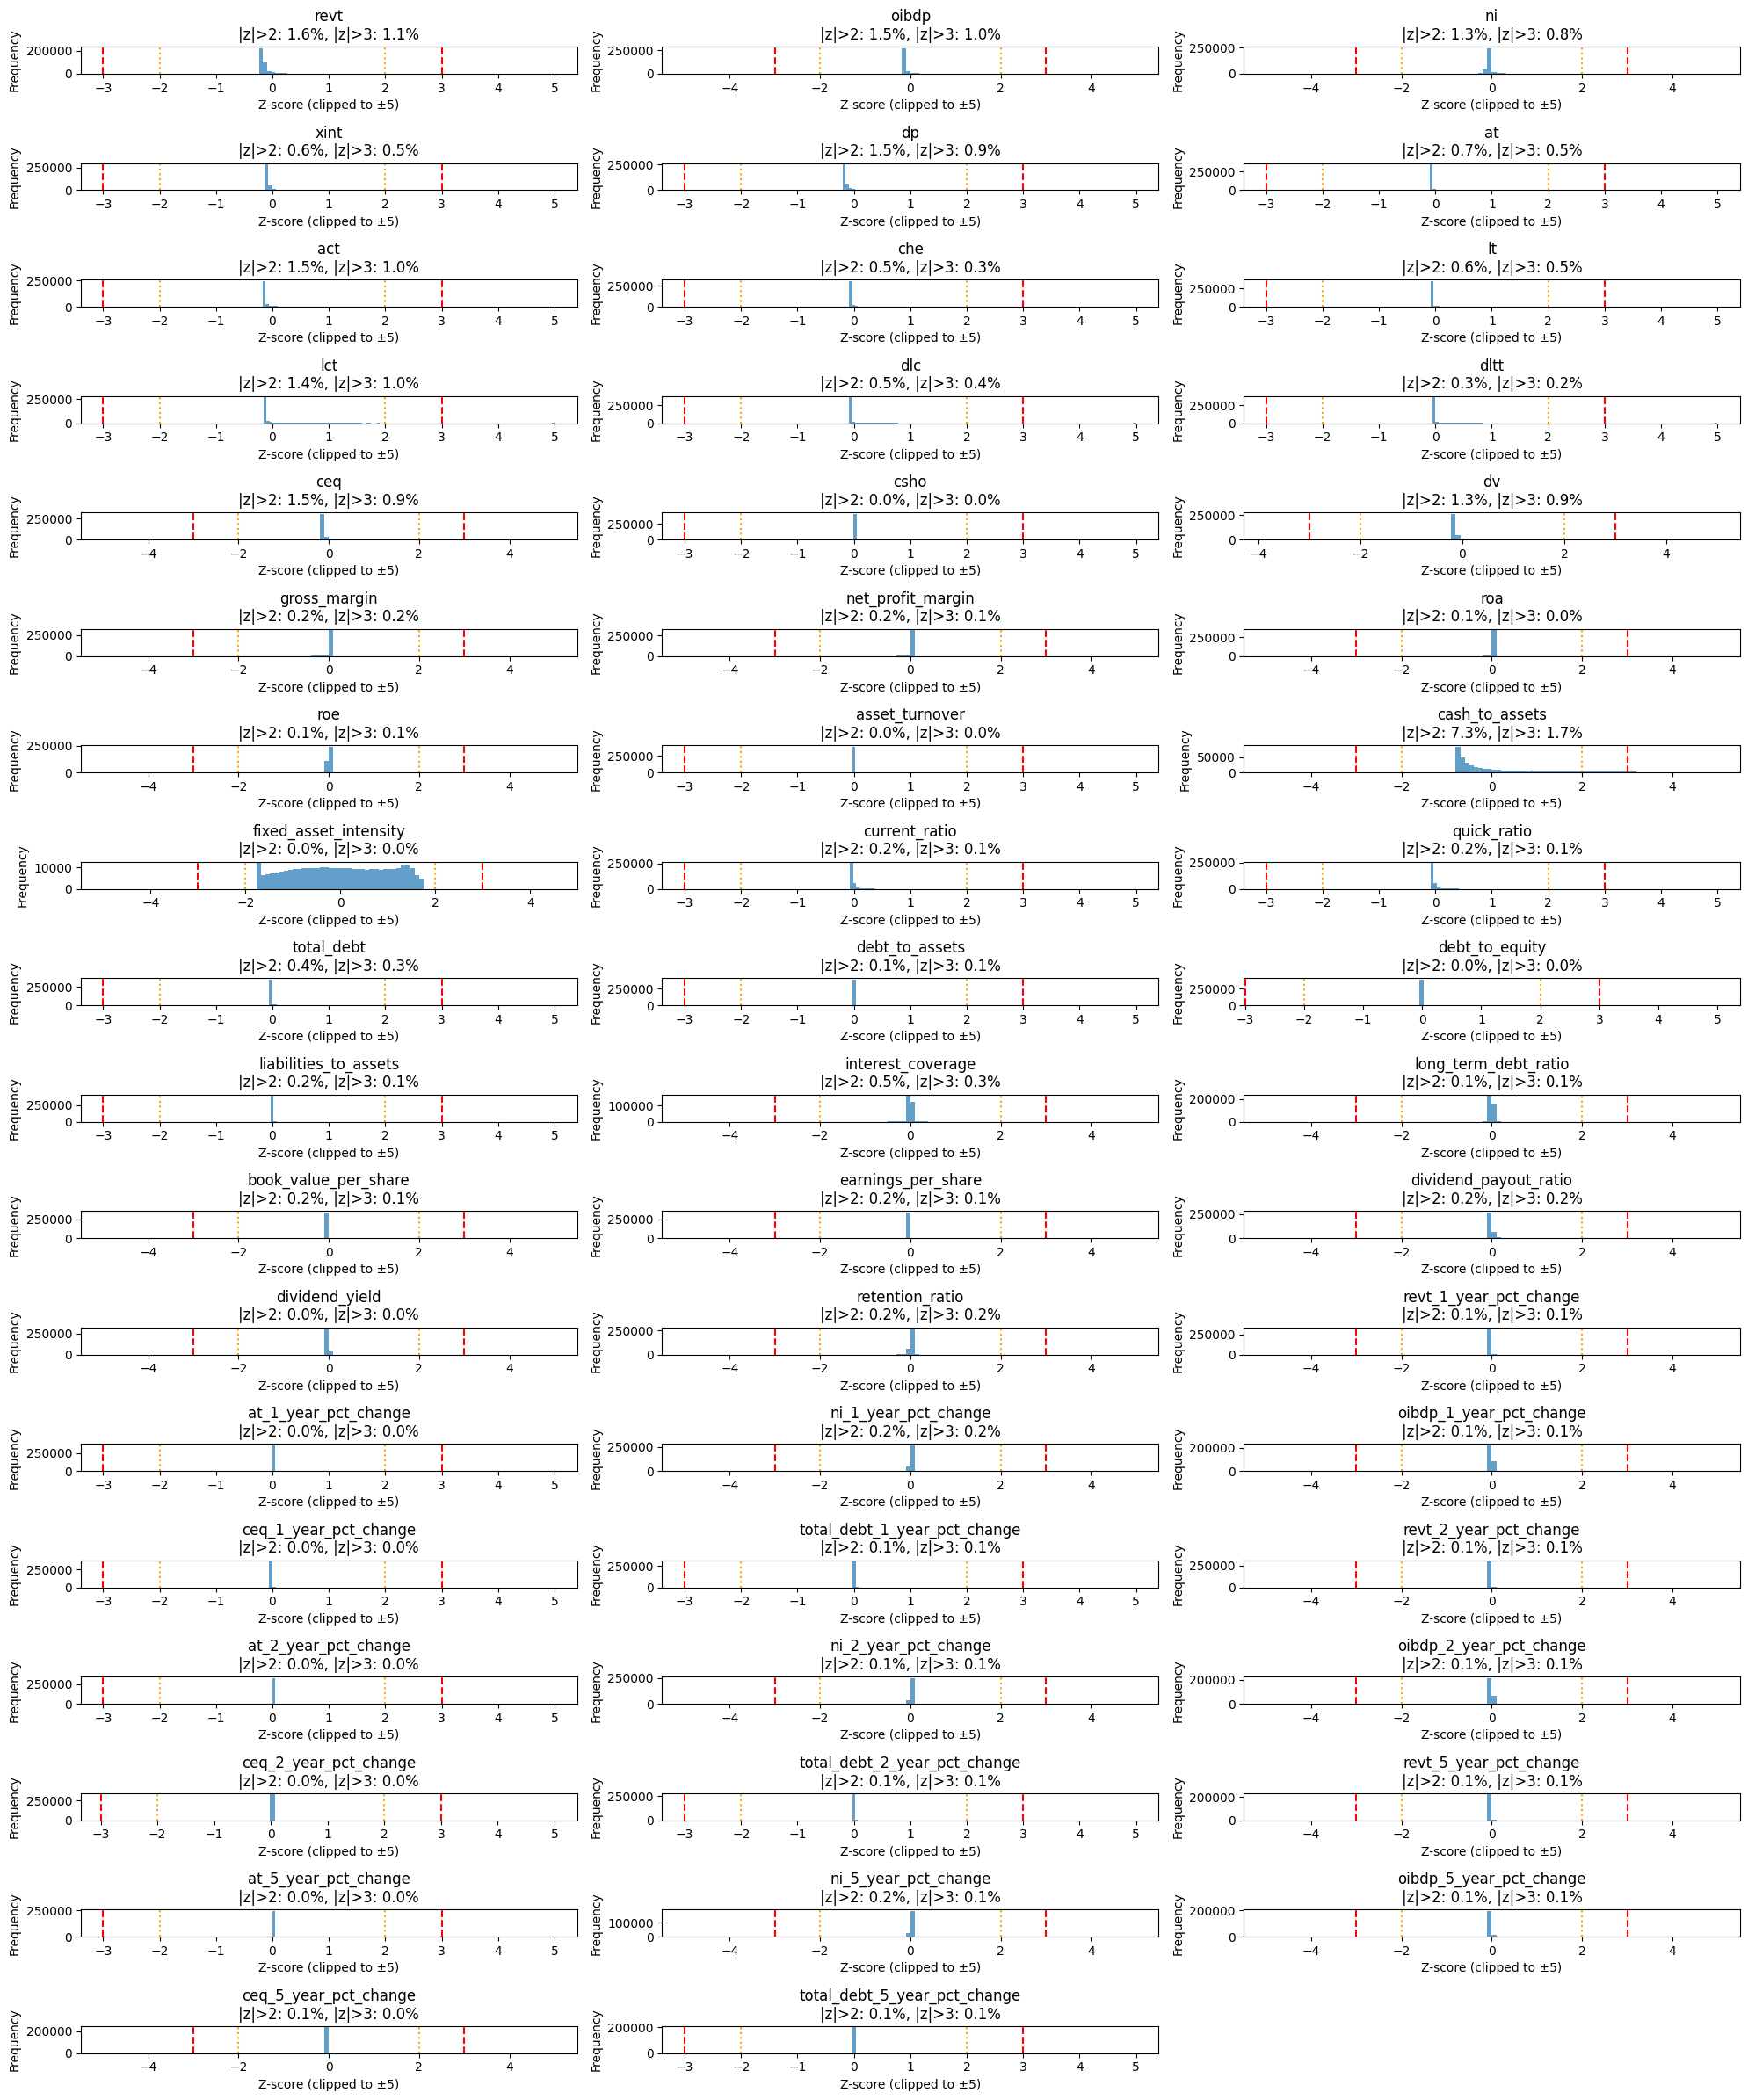

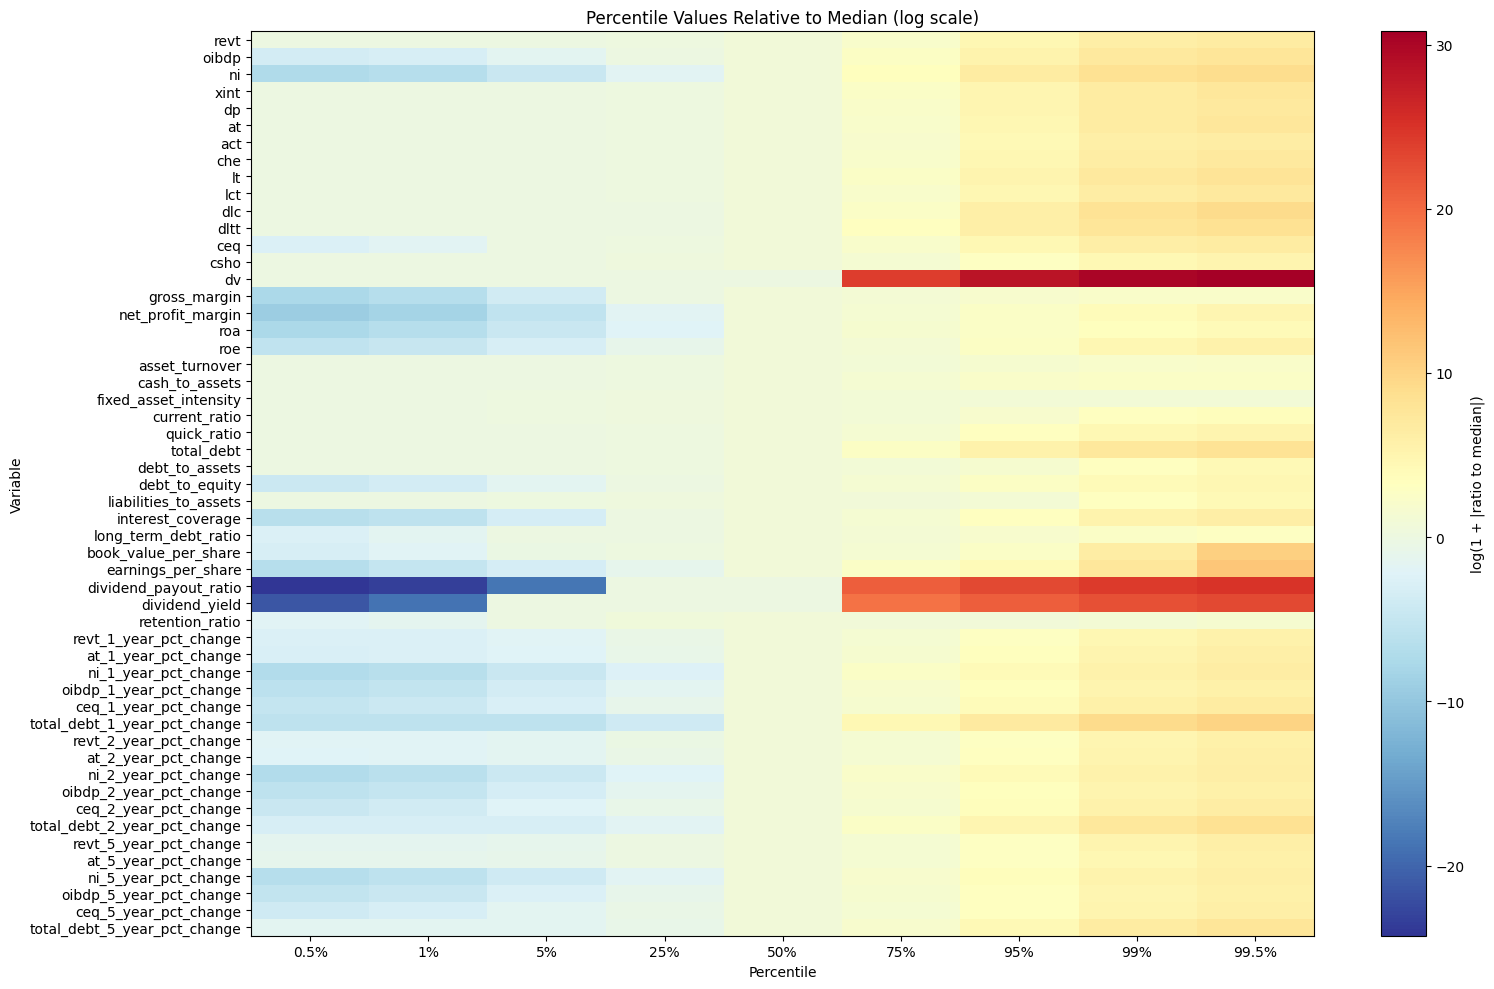

,column,p0.5,p0.5_ratio,p1,p1_ratio,p5,p5_ratio,p25,p25_ratio,p50,p50_ratio,p75,p75_ratio,p95,p95_ratio,p99,p99_ratio,p99.5,p99.5_ratio
0,revt,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,9.988500,0.118609,84.214000,1.0,608.197000,7.222041e+00,8005.000000,9.505545e+01,40339.693200,4.790141e+02,66027.021150,7.840385e+02
1,oibdp,-213.231180,-3.542635e+01,-118.129720,-1.962614e+01,-21.582000,-3.585645e+00,-0.611000,-0.101512,6.019000,1.0,80.100000,1.330786e+01,1302.004200,2.163157e+02,6640.000000,1.103173e+03,11961.820000,1.987343e+03
2,ni,-961.143395,-1.373062e+03,-477.729830,-6.824712e+02,-74.063650,-1.058052e+02,-3.605000,-5.150000,0.700000,1.0,20.720000,2.960000e+01,464.268600,6.632409e+02,2782.156790,3.974510e+03,5016.595000,7.166564e+03
3,xint,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.149000,0.067087,2.221000,1.0,23.688000,1.066547e+01,310.028750,1.395897e+02,1686.227760,7.592201e+02,3871.208500,1.743002e+03
4,dp,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.373000,0.120751,3.089000,1.0,28.083750,9.091534e+00,437.000000,1.414697e+02,2264.000000,7.329233e+02,3833.207870,1.240922e+03
5,at,0.004000,2.591278e-05,0.040000,2.591278e-04,1.177000,7.624835e-03,20.627000,0.133626,154.364000,1.0,1142.928250,7.404111e+00,16205.481700,1.049823e+02,111112.825620,7.198105e+02,243280.165000,1.576016e+03
6,act,0.000000,0.000000e+00,0.005000,1.136635e-04,0.265000,6.024165e-03,6.811000,0.154832,43.989500,1.0,254.029000,5.774764e+00,2880.700300,6.548609e+01,15591.028350,3.544261e+02,26001.084390,5.910748e+02
7,che,0.000000,0.000000e+00,0.000000,0.000000e+00,0.011000,1.328663e-03,0.984000,0.118855,8.279000,1.0,58.338500,7.046564e+00,834.000000,1.007368e+02,5314.628220,6.419408e+02,10174.672040,1.228974e+03
8,lt,0.018000,2.646786e-04,0.050000,7.352184e-04,0.479000,7.043393e-03,7.374000,0.108430,68.007000,1.0,693.303000,1.019458e+01,11116.281200,1.634579e+02,84546.763120,1.243207e+03,195698.700000,2.877626e+03
9,lct,0.010000,4.835122e-04,0.031000,1.498888e-03,0.286000,1.382845e-02,3.459000,0.167247,20.682000,1.0,140.551500,6.795837e+00,2190.000000,1.058892e+02,12672.677380,6.127395e+02,22430.273060,1.084531e+03


In [61]:
'''
plot_winsorization_histograms(compustat_df_1980_deduplicated_extended_growth)
plot_percentile_comparison(compustat_df_1980_deduplicated_extended_growth)
'''

In [64]:
def winsorize_columns(df, cols=None, lower=0.5, upper=1.0):
    """
    Winsorize specified columns by capping extreme values at given percentiles.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset containing financial variables
    cols : list, optional
        List of columns to winsorize. If None, uses default financial columns.
    lower : float, default 0.5
        Lower percentile threshold (0.5 = 0.5th percentile)
    upper : float, default 1.0
        Upper percentile threshold (1.0 = 99th percentile, i.e., top 1%)

    Returns:
    --------
    pandas DataFrame with winsorized columns

    Notes:
    ------
    - Values below the lower percentile are set to the lower percentile value
    - Values above the (100 - upper) percentile are set to that percentile value
    - NaN values are preserved (not affected by winsorization)
    - Original columns are overwritten with winsorized values
    """

    df = df.copy()

    # Default columns if not specified
    if cols is None:
        cols = ['revt', 'oibdp', 'ni', 'xint', 'dp', 'at', 'act', 'che',
                'lt', 'lct', 'dlc', 'dltt', 'ceq', 'csho', 'dv',
                'gross_margin', 'net_profit_margin', 'roa', 'roe', 'asset_turnover','cash_to_assets', 'fixed_asset_intensity', 'current_ratio', 'quick_ratio','total_debt', 'debt_to_assets', 'debt_to_equity', 'liabilities_to_assets','interest_coverage', 'long_term_debt_ratio', 'book_value_per_share','earnings_per_share', 'dividend_payout_ratio', 'dividend_yield', 'retention_ratio','revt_1_year_pct_change', 'at_1_year_pct_change', 'ni_1_year_pct_change','oibdp_1_year_pct_change', 'ceq_1_year_pct_change', 'total_debt_1_year_pct_change','revt_2_year_pct_change', 'at_2_year_pct_change', 'ni_2_year_pct_change','oibdp_2_year_pct_change', 'ceq_2_year_pct_change', 'total_debt_2_year_pct_change', 'revt_5_year_pct_change', 'at_5_year_pct_change', 'ni_5_year_pct_change','oibdp_5_year_pct_change', 'ceq_5_year_pct_change', 'total_debt_5_year_pct_change']

    # Filter to columns that exist in the dataframe
    cols = [c for c in cols if c in df.columns]

    # Store winsorization summary
    summary = []

    for col in cols:
        # Get non-null values
        data = df[col].dropna()

        if len(data) == 0:
            continue

        # Calculate percentile thresholds
        lower_threshold = np.percentile(data, lower)
        upper_threshold = np.percentile(data, 100 - upper)

        # Count affected observations
        n_lower = (df[col] < lower_threshold).sum()
        n_upper = (df[col] > upper_threshold).sum()

        # Apply winsorization
        df[col] = df[col].clip(lower=lower_threshold, upper=upper_threshold)

        # Store summary
        summary.append({
            'column': col,
            'lower_threshold': lower_threshold,
            'upper_threshold': upper_threshold,
            'n_clipped_lower': n_lower,
            'n_clipped_upper': n_upper,
            'pct_clipped_lower': n_lower / len(data) * 100,
            'pct_clipped_upper': n_upper / len(data) * 100
        })

    # Print summary
    summary_df = pd.DataFrame(summary)
    print("Winsorization Summary:")
    print(f"Lower threshold: {lower}th percentile")
    print(f"Upper threshold: {100 - upper}th percentile")
    print("-" * 80)
    print(summary_df.to_string(index=False))

    return df

In [65]:
compustat_df_1980_deduplicated_extended_growth_winsor=winsorize_columns(compustat_df_1980_deduplicated_extended_growth)

Winsorization Summary:
Lower threshold: 0.5th percentile
Upper threshold: 99.0th percentile
--------------------------------------------------------------------------------
                      column  lower_threshold  upper_threshold  n_clipped_lower  n_clipped_upper  pct_clipped_lower  pct_clipped_upper
                        revt         0.000000     40339.693200              535             3971           0.134730           1.000023
                       oibdp      -213.231180      6640.000000             1758             3514           0.500175           0.999781
                          ni      -961.143395      2782.156790             1782             3563           0.500166           1.000051
                        xint         0.000000      1686.227760               61             3777           0.016152           1.000101
                          dp         0.000000      2264.000000               52             3853           0.013490           0.999538
                 

In [66]:
compustat_df_1980_deduplicated_extended_growth_winsor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487606 entries, 0 to 487605
Data columns (total 61 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   gvkey                         487606 non-null  int64  
 1   datadate                      487606 non-null  object 
 2   fyear                         487606 non-null  int64  
 3   conm                          487606 non-null  object 
 4   tic                           487403 non-null  object 
 5   naicsh                        359011 non-null  float64
 6   revt                          397091 non-null  float64
 7   oibdp                         351477 non-null  float64
 8   ni                            356282 non-null  float64
 9   xint                          377662 non-null  float64
 10  dp                            385478 non-null  float64
 11  at                            399664 non-null  float64
 12  act                           334680 non-nul

# 6. & 7. Additional transformations:

In [ ]:
'''
def standardize_columns(df, columns):
    df_copy = df.copy()
    for col in columns:
        df_copy[col] = (df_copy[col] - df_copy[col].mean()) / df_copy[col].std()
    return df_copy
'''

In [ ]:
'''
def log_columns(df, columns):
    df_copy = df.copy()
    for col in columns:
        df_copy[col] = df_copy[col].apply(np.log)
    return df_copy
'''


# Saving code

In [68]:
compustat_df_1980_deduplicated_extended_growth_winsor.to_csv(
    "compustat_df_1980_deduplicated_extended_winsor.csv",
    index=False
)

# done